### I make all imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.nn import PyroSample
from pyro.infer import Predictive

In [3]:
from BayesianNN.BayesianNet import BayesianClassifier

In [4]:
import torchvision.datasets as datasets

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [7]:
import matplotlib.pyplot as plt

In [8]:
import numpy as np

### I dowload all datasets

In [9]:
batch_size = 128

In [10]:
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [11]:
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transf)

In [12]:
train_loader = DataLoader(mnist_train, shuffle=True, batch_size=batch_size)

In [13]:
mnist_test = datasets.MNIST(root="./data", train=False, download=False, transform=transf)
test_loader = DataLoader(mnist_test, shuffle=True, batch_size=batch_size)

In [14]:
example_test = enumerate(test_loader)

### Plotting some numbers

In [15]:
batch_id, (data_ex, label_ex) = next(example_test)

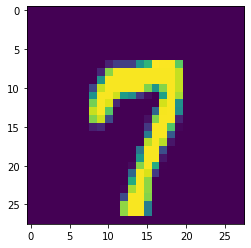

In [16]:
i = np.random.choice(batch_size)
plt.imshow(data_ex[i].numpy().reshape(28, 28))

### Define model and guide

In [17]:
model = BayesianClassifier(layers=[28*28, 256, 128], num_categories=10)


In [18]:
model.layer0

PyroLinear(in_features=784, out_features=256, bias=True)

In [19]:
guide = AutoDiagonalNormal(model)

In [20]:
optim = Adam({"lr":0.001})

In [21]:
#guide = guide.cuda()
#model = model.cuda()

In [22]:
svi = SVI(model=model, guide=guide, optim=optim, loss=Trace_ELBO())

In [23]:
epochs = 30

### Loop over the events to minimize the loss

In [24]:
train_iterator = enumerate(train_loader)

In [25]:
for j in range(epochs):
    for x, y in iter(train_loader):
        x_flat = x.view(-1, 28*28).cuda()
        y =y.cuda()
        
        loss = svi.step(x_flat, y)
    

    print("Epoch: {},  loss: {}".format(j, loss))       

Epoch: 0,  loss: 346200.43140792847
Epoch: 1,  loss: 248988.53353405
Epoch: 2,  loss: 160000.8528327942
Epoch: 3,  loss: 87928.24655342102
Epoch: 4,  loss: 40757.3731842041
Epoch: 5,  loss: 18986.727725982666
Epoch: 6,  loss: 10294.516906738281
Epoch: 7,  loss: 6809.459182739258
Epoch: 8,  loss: 5263.723731994629
Epoch: 9,  loss: 4564.251871109009
Epoch: 10,  loss: 3995.4052925109863
Epoch: 11,  loss: 3522.2843914031982
Epoch: 12,  loss: 3566.34712600708
Epoch: 13,  loss: 3048.6378631591797
Epoch: 14,  loss: 2905.4894046783447
Epoch: 15,  loss: 3175.595865249634
Epoch: 16,  loss: 2697.7340965270996
Epoch: 17,  loss: 3625.7393941879272
Epoch: 18,  loss: 2908.924741744995
Epoch: 19,  loss: 2439.8308572769165
Epoch: 20,  loss: 2391.85235786438
Epoch: 21,  loss: 2313.1302242279053
Epoch: 22,  loss: 2305.4577655792236
Epoch: 23,  loss: 2228.4515714645386
Epoch: 24,  loss: 2297.850425720215
Epoch: 25,  loss: 2246.893783569336
Epoch: 26,  loss: 2237.328435897827
Epoch: 27,  loss: 2145.7452039

In [26]:
batch_id, (data_ex, label_ex) = next(example_test)

In [27]:
x = data_ex.view(-1, 28*28).cuda()

In [28]:
x.is_cuda

True

In [29]:
a = model(x)

In [30]:
a.is_cuda

True

In [31]:
model

BayesianClassifier(
  (layer0): PyroLinear(in_features=784, out_features=256, bias=True)
  (layer1): PyroLinear(in_features=256, out_features=128, bias=True)
  (output_layer): PyroLinear(in_features=128, out_features=10, bias=True)
)

In [32]:
x = data_ex.view(-1, 28*28)

In [33]:
x.is_cuda

False

In [34]:
model = model.cpu()

In [35]:
a = model.cpu()

In [37]:
guide.requires_grad_(False)

AutoDiagonalNormal()

In [38]:
prediction = Predictive(model=model, guide=guide, num_samples=300, return_sites=["obs", "_RETURN"])

In [40]:
pred = prediction(data_ex.view(-1, 28*28).cuda())

### Plotting result

In [48]:
i = np.random.choice(64)

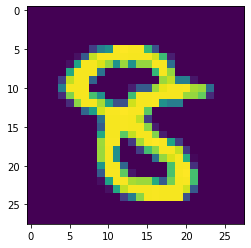

In [49]:
plt.imshow(data_ex[i].view(28, 28))

In [50]:
a = pred["obs"][:, i].cpu()

In [60]:
num = torch.argmax(pred["_RETURN"][:, i, :], axis=1)

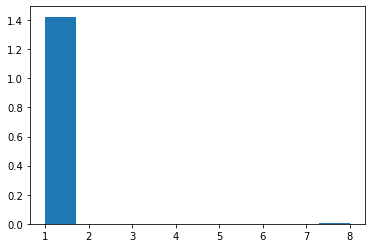

In [61]:
a = plt.hist(num, density=True)

In [62]:
new_pred = torch.mean(pred["_RETURN"][:, i, :], axis=0)

<BarContainer object of 10 artists>

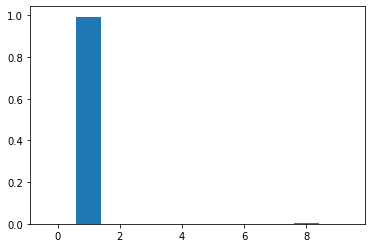

In [63]:
plt.bar(x=[0,1,2,3,4,5,6,7,8,9], height=new_pred)

In [64]:
torch.argmax(new_pred)

tensor(1)

### Let's see how it predict the noise

In [65]:
fake_sample = torch.randn(size=(100, 28, 28))

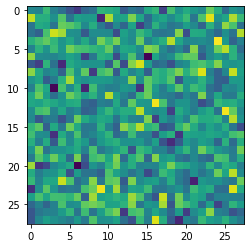

In [66]:
i = np.random.choice(100)
plt.imshow(fake_sample[i])

In [67]:
pred_fake = prediction(fake_sample.view(-1, 28*28))

In [92]:
i = np.random.choice(100)

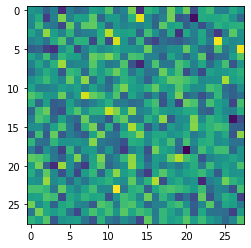

In [93]:
plt.imshow(fake_sample[i].view(28, 28))

(array([0.22675737, 0.        , 0.24943311, 0.        , 0.20408163,
        0.        , 0.1814059 , 0.        , 0.22675737, 0.        ,
        0.        , 0.22675737, 0.        , 0.20408163, 0.        ,
        0.24943311, 0.        , 0.22675737, 0.        , 0.22675737]),
 array([0.  , 0.45, 0.9 , 1.35, 1.8 , 2.25, 2.7 , 3.15, 3.6 , 4.05, 4.5 ,
        4.95, 5.4 , 5.85, 6.3 , 6.75, 7.2 , 7.65, 8.1 , 8.55, 9.  ]),
 <BarContainer object of 20 artists>)

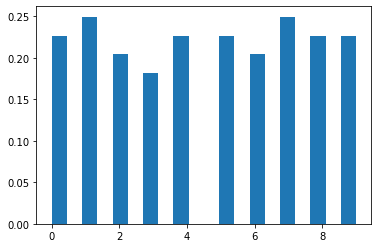

In [12]:
a = plt.hist(pred_fake["obs"][:, i], density=True)